<a href="https://colab.research.google.com/github/tgarcia14/DigitalBuilders/blob/main/evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import train_test_split, cross_val_score
import scipy.stats as stats
import statsmodels as sm
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from mpl_toolkits import mplot3d
import statsmodels.api as sm
from sklearn.feature_selection import r_regression
from sklearn.utils import resample
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn import metrics

In [49]:
import requests
url = 'https://data.wa.gov/api/views/sb4j-ca4h/rows.json?accessType=DOWNLOAD'
response = requests.get(url)
data = response.json()
records = data['data']
column_names = [column['name'] for column in data['meta']['view']['columns']]
data_breach_df = pd.DataFrame(records, columns=column_names)

In [50]:
# Copy the DataFrame to avoid modifying the original
cleaned_df = data_breach_df.copy()

# Remove unnecessary columns (if any)
# Example: Drop columns like 'ID' or any irrelevant text-heavy fields
cleaned_df = cleaned_df.drop(['DateEnd'], axis=1)
cleaned_df = cleaned_df.drop(['Id'], axis=1)
cleaned_df = cleaned_df.drop(['EntityState'], axis=1)
# Handle missing values
# Here, missing data with impute data
cleaned_df['CyberattackType'] = cleaned_df['CyberattackType'].fillna('Other')
cleaned_df['BusinessType'] = cleaned_df['BusinessType'].fillna('Other')
cleaned_df['DataBreachCause'] = cleaned_df['DataBreachCause'].fillna('Unknown/unclear')

# Convert data types if needed
# Convert 'DateAware' and 'DateSubmitted' columns to datetime objects for analysis
cleaned_df['DateAware'] = pd.to_datetime(cleaned_df['DateAware'])
cleaned_df['DateSubmitted'] = pd.to_datetime(cleaned_df['DateSubmitted'])

# Standardize string values (if needed)
# Example: Convert all string data to lowercase for consistency
for column in cleaned_df.select_dtypes(include=['object']):
    cleaned_df[column] = cleaned_df[column].str.lower()

#Converts WashingtonAffected to an INT
cleaned_df['WashingtoniansAffected'] = cleaned_df['WashingtoniansAffected'].fillna(0).astype(int)
cleaned_df['WashingtoniansAffected'] = cleaned_df['WashingtoniansAffected'].astype(int)
# Remove duplicates
cleaned_df = cleaned_df.drop_duplicates()

# Check for inconsistencies or outliers in numeric columns
# Example: Check for outliers in 'WashingtoniansAffected' and 'DaysToContainBreach'
print(cleaned_df['WashingtoniansAffected'].describe())
print(cleaned_df['DaysToContainBreach'].describe())

# Optional: Handle specific outliers or inconsistencies
# Example: Remove extreme outliers based on domain knowledge
# cleaned_df = cleaned_df[cleaned_df['WashingtoniansAffected'] < threshold_value]
# Mean imputation for 'DaysToContainBreach' column
####
cleaned_df['DaysToContainBreach'] = pd.to_numeric(cleaned_df['DaysToContainBreach'], errors='coerce')
cleaned_df['DaysToContainBreach'] = cleaned_df['DaysToContainBreach'].fillna(cleaned_df['DaysToContainBreach'].mean()).astype(int)

#Mean imputation for  Days to Identify and conversion to Int
####
cleaned_df.loc[:, 'DaysToIdentifyBreach'] = pd.to_numeric(cleaned_df['DaysToIdentifyBreach'], errors='coerce')
cleaned_df['DaysToIdentifyBreach'] = cleaned_df['DaysToIdentifyBreach'].fillna(cleaned_df['DaysToIdentifyBreach'].mean()).astype(int)
# Mean imputations for Days of exposure and conversion to Int
cleaned_df.loc[:, 'DaysOfExposure'] = pd.to_numeric(cleaned_df['DaysOfExposure'], errors='coerce')
cleaned_df['DaysOfExposure'] = cleaned_df['DaysOfExposure'].fillna(cleaned_df['DaysOfExposure'].mean()).astype(int)

#Mean imputation for DaysBreachLifecycle and conversion to Int
cleaned_df.loc[:, 'DaysBreachLifecycle'] = pd.to_numeric(cleaned_df['DaysBreachLifecycle'], errors='coerce')
cleaned_df['DaysBreachLifecycle'] = cleaned_df['DaysBreachLifecycle'].fillna(cleaned_df['DaysBreachLifecycle'].mean()).astype(int)

#DaysElapsedBetweenEndAndDiscovery
cleaned_df.loc[:, 'DaysElapsedBetweenEndAndDiscovery'] = pd.to_numeric(cleaned_df['DaysElapsedBetweenEndAndDiscovery'], errors='coerce')
cleaned_df['DaysElapsedBetweenEndAndDiscovery'] = cleaned_df['DaysElapsedBetweenEndAndDiscovery'].fillna(cleaned_df['DaysElapsedBetweenEndAndDiscovery'].mean()).astype(int)

#DaysElapsedBeforeNotification
cleaned_df.loc[:, 'DaysElapsedBeforeNotification'] = pd.to_numeric(cleaned_df['DaysElapsedBeforeNotification'], errors='coerce')
cleaned_df['DaysElapsedBeforeNotification'] = cleaned_df['DaysElapsedBeforeNotification'].fillna(cleaned_df['DaysElapsedBeforeNotification'].mean()).astype(int)


cleaned_df.drop('sid', axis=1, inplace=True)
cleaned_df.drop('id', axis=1, inplace=True)
cleaned_df.drop('position', axis=1, inplace=True)
cleaned_df.drop('created_at', axis=1, inplace=True)
cleaned_df.drop('created_meta', axis=1, inplace=True)
cleaned_df.drop('updated_at', axis=1, inplace=True)
cleaned_df.drop('updated_meta', axis=1, inplace=True)
cleaned_df.drop('meta', axis=1, inplace=True)

cleaned_df['DateStart'] = pd.to_datetime(cleaned_df['DateStart'])

cleaned_df['Year'] = cleaned_df['Year'].astype(int)
cleaned_df['YearText'] = cleaned_df['YearText'].astype(int)
# Show the first few rows of the cleaned dataset

count    1.213000e+03
mean     3.035297e+04
std      1.783883e+05
min      0.000000e+00
25%      8.100000e+02
50%      1.687000e+03
75%      6.586000e+03
max      3.243664e+06
Name: WashingtoniansAffected, dtype: float64
count     982
unique     62
top         0
freq      771
Name: DaysToContainBreach, dtype: object


<ipython-input-50-41454052aa62>:47: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cleaned_df['DaysToIdentifyBreach'] = cleaned_df['DaysToIdentifyBreach'].fillna(cleaned_df['DaysToIdentifyBreach'].mean()).astype(int)
<ipython-input-50-41454052aa62>:50: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cleaned_df['DaysOfExposure'] = cleaned_df['DaysOfExposure'].fillna(cleaned_df['DaysOfExposure'].mean()).astype(int)
<ipython-input-50-41454052aa62>:54: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a f

In [51]:
cleaned_df[['DaysToContainBreach','DaysToIdentifyBreach','DaysBreachLifecycle','DaysOfExposure','DaysElapsedBetweenEndAndDiscovery','DaysElapsedBeforeNotification']]

,DaysToContainBreach,DaysToIdentifyBreach,DaysBreachLifecycle,DaysOfExposure,DaysElapsedBetweenEndAndDiscovery,DaysElapsedBeforeNotification
0,4,0,4,4,72,41
1,5,118,123,93,72,453
2,0,60,60,5,55,23
3,5,0,123,93,72,298
4,0,6,6,6,72,60
...,...,...,...,...,...,...
1208,0,4,4,3,1,164
1209,0,16,16,2,14,55
1210,0,9,9,9,72,164
1211,0,0,0,0,72,161


a sample is drawn from the dataset since all the data wont fit in the plots

In [52]:
sample_df = cleaned_df.sample(n=150, random_state=1)

In [53]:
sample_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 150 entries, 1122 to 915
Data columns (total 22 columns):
 #   Column                             Non-Null Count  Dtype         
---  ------                             --------------  -----         
 0   DateAware                          148 non-null    datetime64[ns]
 1   DateSubmitted                      150 non-null    datetime64[ns]
 2   DataBreachCause                    150 non-null    object        
 3   DateStart                          135 non-null    datetime64[ns]
 4   Name                               150 non-null    object        
 5   CyberattackType                    150 non-null    object        
 6   WashingtoniansAffected             150 non-null    int64         
 7   IndustryType                       150 non-null    object        
 8   BusinessType                       150 non-null    object        
 9   Year                               150 non-null    int64         
 10  YearText                           150 n

# Linear Regression

Outliers are removed using z-scores greater than three and the lengths are checked so they match up

In [54]:
sample_df['z_scoreX'] = (sample_df['DaysToIdentifyBreach'] -sample_df['DaysToIdentifyBreach'].mean()) / sample_df['DaysToIdentifyBreach'].std()
sample_df = sample_df.loc[sample_df['z_scoreX'].abs() <= 3]

sample_df['z_scoreY'] = (sample_df['DaysOfExposure'] - sample_df['DaysOfExposure'].mean()) / sample_df['DaysOfExposure'].std()
sample_df = sample_df.loc[sample_df['z_scoreY'].abs() <= 3]

print(len(sample_df[['DaysToIdentifyBreach']]))
print(len(sample_df[['DaysOfExposure']]))

146
146


The days to identify a breach and the days of exposure are plotted

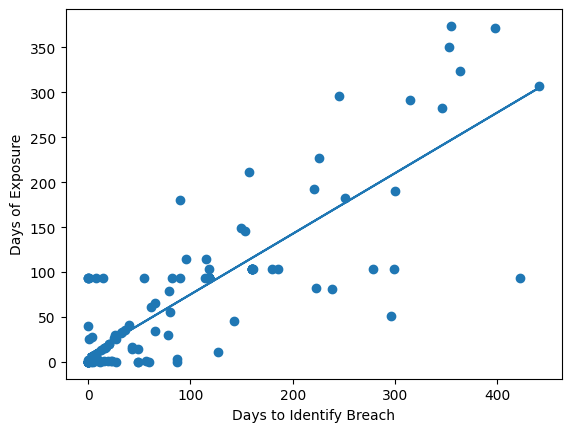

In [55]:
X = sample_df["DaysToIdentifyBreach"]
y = sample_df["DaysOfExposure"]
X = np.asarray(X)
y = np.asarray(y)
linModel = LinearRegression()
linModel.fit(X.reshape(-1,1), y.reshape(-1,1))
y_pred = np.ravel(linModel.predict(X.reshape(-1,1)))
plt.scatter(X,y)
plt.plot(X, y_pred)
plt.xlabel("Days to Identify Breach")
plt.ylabel("Days of Exposure")
plt.show()

In [56]:
print("mean squared error = ", metrics.mean_squared_error(y, y_pred))
print("root mean squared error = ", metrics.mean_squared_error(y, y_pred, squared=False))
print("mean absolute error = ", metrics.mean_absolute_error(y, y_pred))
r = r_regression(X.reshape(-1,1), np.ravel(y))[0]
print('r_squared = ', r**2, end='\n\n')

mean squared error =  1918.8729432131504
root mean squared error =  43.804941995317726
mean absolute error =  26.741649605688643
r_squared =  0.7153951887719383



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


values are not too far away between predicted and observed, and this r-square supports a positive association

In [57]:
print(np.mean(sample_df["DaysToIdentifyBreach"]))
print(np.mean(sample_df["DaysOfExposure"]))

83.29452054794521
63.86986301369863


# Linear Model Cross Validation

In [58]:
trainingData, testData = train_test_split(sample_df, test_size=0.3)
X = trainingData[["DaysToIdentifyBreach"]].values.reshape(-1,1)
y = trainingData[["DaysOfExposure"]].values.reshape(-1,1)
linModel = LinearRegression()
linModel.fit(X, y)
yPredicted = linModel.predict(X)

In [59]:
ten_fold_scores = -cross_val_score(linModel, X, y, scoring='neg_mean_squared_error', cv=10)
LOOCV_scores = -cross_val_score(linModel, X, y, scoring='neg_mean_squared_error', cv=40)
print('ten-fold average MSE =', np.mean(ten_fold_scores), '\n', ten_fold_scores)
print('\nk-fold average MSE =', np.mean(LOOCV_scores), '\n', LOOCV_scores)

ten-fold average MSE = 2587.9479238298677 
 [6887.48454768 1161.43464473 2982.36156288 1604.38184569  781.37178279
 2778.12118862 1220.7169048  1815.11194044 4605.5133577  2042.98146296]

k-fold average MSE = 2580.5267692972084 
 [   38.85821952 18018.43554174  5157.3344152   2906.99615989
  3561.20141949    21.63229381   452.23702769    31.51454727
  2372.96725919   220.32911203  5815.88805317  4879.37488186
   157.07953389   379.52924851   553.89160517  1259.47265519
   701.90998861  2107.94399715  6302.38910562   830.70944599
    90.44056631   850.78388142   127.4730443    219.00323672
  4150.78286638   203.48147876  3905.59995681    62.88984798
    28.66818772  4829.44538546  3905.59995681  3945.3289524
   257.52432453 14285.42364626   134.39846388  3415.42385306
    91.74727584  5745.20516273    60.70742265  1141.44875089]


the mean squared errors are fairly close to the other model

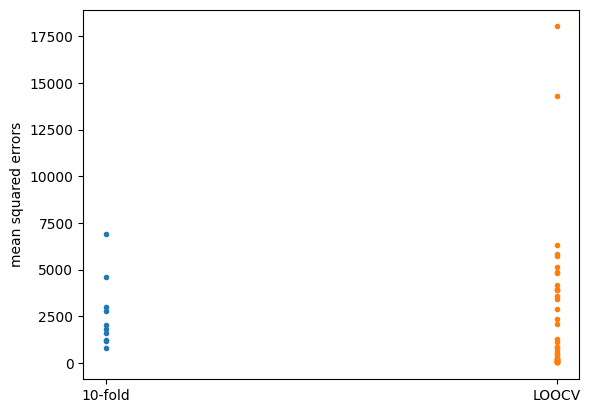

In [60]:
plt.plot(np.zeros_like(ten_fold_scores), ten_fold_scores, '.')
plt.plot(np.zeros_like(LOOCV_scores) + 1, LOOCV_scores, '.')
plt.ylabel('mean squared errors');
plt.xticks([0,1], ['10-fold', 'LOOCV']);

In [61]:
cross_val_score(linModel,X,y,cv=5)

array([0.58636552, 0.77890268, 0.26693674, 0.77030947, 0.50569658])

# Bootstrap Method to Linear Model

In [62]:
#"DaysToIdentifyBreach" "DaysOfExposure"
copy = sample_df.copy()
bootstrapErrors = []
for i in range(0,40):
  boot = resample(copy, replace=True,n_samples=28)
  oob = copy[~copy.index.isin(boot.index)]

  XBoot = boot[['DaysToIdentifyBreach']].values.reshape(-1,1)
  yBoot = boot[['DaysOfExposure']].values.reshape(-1,1)
  linModel = LinearRegression()
  linModel.fit(XBoot, yBoot)
  XOob = oob[['DaysToIdentifyBreach']].values.reshape(-1,1)
  YOob = oob[['DaysOfExposure']].values.reshape(-1,1)
  YOobPredicted = linModel.predict(XOob)
  bootError = mean_squared_error(YOob, YOobPredicted)
  bootstrapErrors.append(bootError)
print("mean = ", np.mean(bootstrapErrors))
print("std dev = ", np.std(bootstrapErrors))

mean =  2595.603357967773
std dev =  703.104803765354


This sample shows a mean squared error similar to the other methods

# Train and Test Split for Linear Model

In [63]:
X = sample_df[["DaysToIdentifyBreach"]]
y = sample_df[["DaysOfExposure"]]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
X_test = np.asarray(X_test)
y_test = np.asarray(y_test)
linModel = LinearRegression()
linModel.fit(X_train.values.reshape(-1,1), y_train.values.reshape(-1,1))
y_pred = np.ravel(linModel.predict(X_test.reshape(-1,1)))

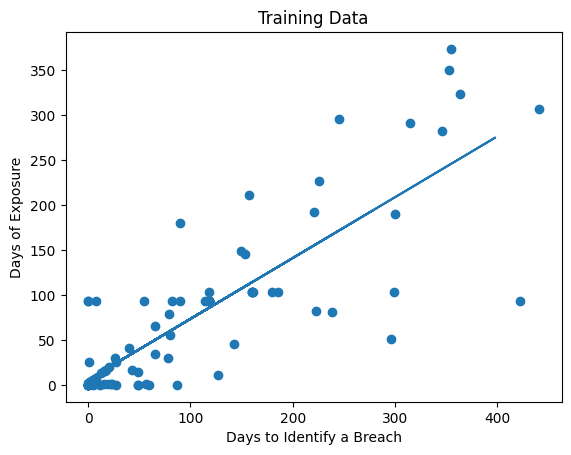

In [64]:
plt.scatter(X_train, y_train)
plt.xlabel("Days to Identify a Breach")
plt.ylabel("Days of Exposure")
plt.title("Training Data")
plt.plot(X_test, y_pred)
plt.show()

In [65]:
yPrediction = np.ravel(linModel.predict(X_train))
print("mean squared error = ", metrics.mean_squared_error(y_train, yPrediction))
print("root mean squared error = ", metrics.mean_squared_error(y_train, yPrediction, squared=False))
print("mean absolute error = ", metrics.mean_absolute_error(y_train, yPrediction))
print('r_squared = ', r2_score(y_train, yPrediction), end='\n\n')

mean squared error =  2265.464154240219
root mean squared error =  47.59689227502379
mean absolute error =  29.03233691722541
r_squared =  0.7031749877480054



/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


there is lower errors that shows this is a good model to use

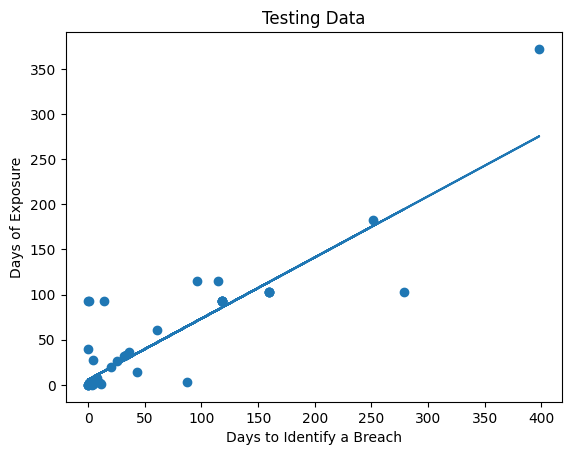

In [66]:
plt.scatter(X_test, y_test)
plt.xlabel("Days to Identify a Breach")
plt.ylabel("Days of Exposure")
plt.title("Testing Data")
plt.plot(X_test, y_pred)
plt.show()

In [67]:
yPrediction = np.ravel(linModel.predict(X_test))
print("mean squared error = ", metrics.mean_squared_error(y_test, yPrediction))
print("root mean squared error = ", metrics.mean_squared_error(y_test, yPrediction, squared=False))
print("mean absolute error = ", metrics.mean_absolute_error(y_test, yPrediction))
print('r_squared = ', r2_score(y_test, yPrediction), end='\n\n')

mean squared error =  1124.841283226272
root mean squared error =  33.538653569072686
mean absolute error =  20.02895427772555
r_squared =  0.75500193682365



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


the values are higher but that can be expected with a different sample and the model still works

# Multiple Features

In [68]:
sample_df['z_scoreY'] = (sample_df['DaysElapsedBetweenEndAndDiscovery'] - sample_df['DaysElapsedBetweenEndAndDiscovery'].mean()) / sample_df['DaysElapsedBetweenEndAndDiscovery'].std()
sample_df = sample_df.loc[sample_df['z_scoreY'].abs() <= 3]
print(len(sample_df[['DaysToIdentifyBreach']]))
print(len(sample_df[['DaysElapsedBetweenEndAndDiscovery']]))
print(len(sample_df[['DaysOfExposure']]))

143
143
143


outliers are removed

A linear model is done between another feature to check the data is a good fit

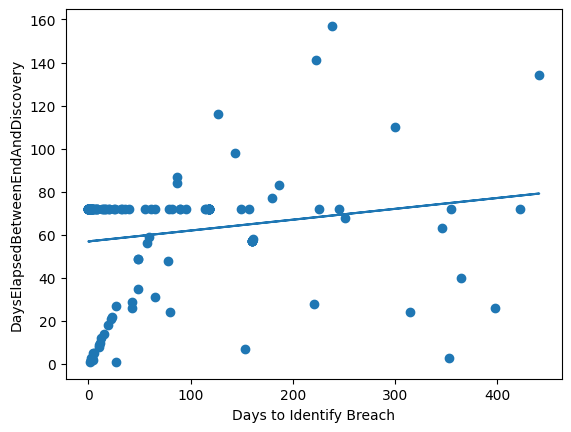

In [69]:
X = sample_df["DaysToIdentifyBreach"]
y = sample_df["DaysElapsedBetweenEndAndDiscovery"]
X = np.asarray(X)
y = np.asarray(y)
linModel = LinearRegression()
linModel.fit(X.reshape(-1,1), y.reshape(-1,1))
y_pred = np.ravel(linModel.predict(X.reshape(-1,1)))
plt.scatter(X,y)
plt.plot(X, y_pred)
plt.xlabel("Days to Identify Breach")
plt.ylabel("DaysElapsedBetweenEndAndDiscovery")
plt.show()

a 3D plot is made showing observed and expected values

Text(0.5, 0, 'Days of Exposure')

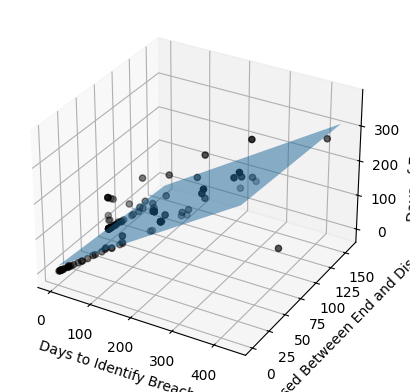

In [70]:
X = sample_df[['DaysToIdentifyBreach', 'DaysElapsedBetweenEndAndDiscovery']].values.reshape(-1,2)
y = sample_df[['DaysOfExposure']].values.reshape(-1,1)
linModel = LinearRegression()
linModel.fit(X, y)
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(X[:,0], X[:,1], y, color='black')
xDaysToIdentifyBreach, xDaysElapsedBetweenEndAndDiscovery = np.meshgrid(
    np.linspace(X[:,0].min(), X[:,0].max(), 2),
    np.linspace(X[:,1].min(), X[:,1].max(), 2),
)
yDaysOfExposure = (linModel.intercept_[0]
                        + linModel.coef_[0,0] * xDaysToIdentifyBreach
                        + linModel.coef_[0,1] * xDaysElapsedBetweenEndAndDiscovery)
ax.plot_surface(xDaysToIdentifyBreach, xDaysElapsedBetweenEndAndDiscovery, yDaysOfExposure, alpha=0.5)
ax.set_xlabel('Days to Identify Breach')
ax.set_ylabel('Days Elapsed Betweeen End and Discovery')
ax.set_zlabel('Days of Exposure')

even with low sample sizes the jupyter plots are not as good as colab

In [71]:
y_pred = linModel.predict(X)
mse = metrics.mean_squared_error(y, y_pred)
rmse = mse**0.5
mae = metrics.mean_absolute_error(y, y_pred)
print("mean squared error = ", mse)
print("root mean squared error = ", rmse)
print("mean absolute error = ", mae)
print('r_squared = ', r2_score(y, y_pred), end='\n\n')

mean squared error =  1592.1232274837591
root mean squared error =  39.90141886554611
mean absolute error =  24.26412365095181
r_squared =  0.7679425007350014



these values are fairly low for the datasets and has a high r-squared value, so this shows a good association

# Cross Validation for multiple features

In [72]:
#'Days to Identify Breach' 'Days Elapsed Betweeen End and Discovery' 'Days of Exposure'
X = sample_df[["DaysToIdentifyBreach", "DaysElapsedBetweenEndAndDiscovery"]].values.reshape(-1,2)
y = sample_df[["DaysOfExposure"]].values.reshape(-1,1)
multi = LinearRegression()
multi = multi.fit(X,y)
tenFoldMulti = -cross_val_score(multi,X,y,scoring='neg_mean_squared_error',cv=10)
loocvMulti = -cross_val_score(multi,X,y,scoring='neg_mean_squared_error',cv=40)
print('ten-fold average MSE =', np.mean(tenFoldMulti), '\n', tenFoldMulti)
print('\nk-fold average MSE =', np.mean(loocvMulti), '\n', loocvMulti)

ten-fold average MSE = 1730.0709543767284 
 [1856.19790024 1186.57324919 4835.03265842  716.20716239 2273.19482532
  268.71054186 2336.21594164 1392.32999271 1355.25602219 1080.99124981]

k-fold average MSE = 1715.1539900921641 
 [2.42631341e+03 3.83838510e+03 3.13871935e+02 8.60847221e+02
 2.08217181e+03 2.05578579e+02 1.11133203e+03 1.96671440e+03
 2.00103969e+03 1.48590088e+04 1.35653978e+02 7.41021857e+02
 3.34277880e+02 4.57624505e+01 1.44688723e+03 7.95733517e+02
 1.09811247e+03 6.25681376e+03 4.18801385e+00 4.04056519e+02
 4.06716156e+02 3.17152788e+03 8.84473967e+02 2.07060558e+02
 2.33180458e+03 2.86774423e+03 1.39558575e+01 1.84746973e+02
 3.05287209e+02 1.30396596e+03 4.49055192e+03 3.06966425e+02
 3.63118762e+02 3.52606606e+03 1.36469603e+02 2.61560649e+03
 1.59782664e+03 2.63501310e+03 2.18003800e+02 1.11482848e+02]


the mean squared errors are very similar to the other methods used

In [73]:
#ten_fold_scores LOOCV_scores,  #tenFoldMulti loocvMulti
mse = np.concatenate([ten_fold_scores, LOOCV_scores, tenFoldMulti, loocvMulti])
model = np.concatenate([['Linear'] * (10+40), ['Multiple'] * (10+40)])
cv = np.concatenate([['10-fold']*10, ['LOOCV'] * 40, ['10-fold']*10, ['LOOCV'] *40])
results = pd.DataFrame({'MSE': mse, 'Model': model, 'CV': cv})
results

,MSE,Model,CV
0,6887.484548,Linear,10-fold
1,1161.434645,Linear,10-fold
2,2982.361563,Linear,10-fold
3,1604.381846,Linear,10-fold
4,781.371783,Linear,10-fold
...,...,...,...
95,2615.606492,Multiple,LOOCV
96,1597.826638,Multiple,LOOCV
97,2635.013099,Multiple,LOOCV
98,218.003800,Multiple,LOOCV


<function matplotlib.pyplot.show(close=None, block=None)>

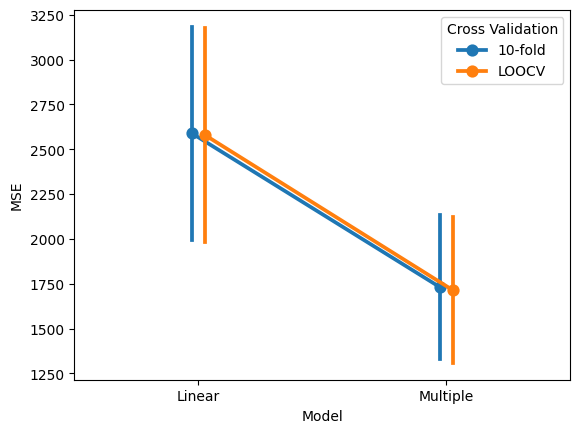

In [74]:
plt.figure()
p = sns.pointplot(data=results, x='Model', y='MSE',hue='CV', dodge=True,errorbar='se')
p.set_xlabel('Model')
p.set_ylabel('MSE')
plt.legend(title='Cross Validation')
plt.show

this plot changes when the sample is updated, it can appear to lean to the other side

In [75]:
print(len(sample_df[['DaysToIdentifyBreach']]))
print(len(sample_df[['DaysElapsedBetweenEndAndDiscovery']]))
print(len(sample_df[['DaysOfExposure']]))

143
143
143


# Train Test Split for multiple features

this model is developed to try and find a better fit to the 3D plot

Text(0.5, 0, 'Days of Exposure')

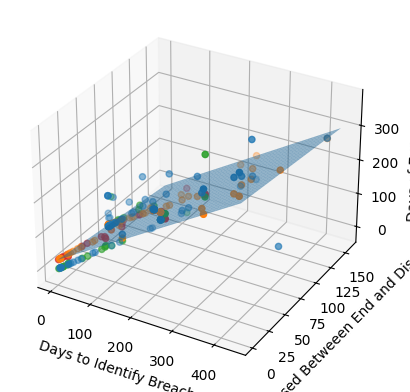

In [76]:
X = sample_df[['DaysToIdentifyBreach', 'DaysElapsedBetweenEndAndDiscovery']]
y = sample_df[['DaysOfExposure']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
linModel = LinearRegression()
linModel.fit(X_train, y_train)
y_pred = linModel.predict(X_test)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter3D(X_train['DaysToIdentifyBreach'], X_train['DaysElapsedBetweenEndAndDiscovery'], y_train)
ax.scatter3D(X_train['DaysToIdentifyBreach'], X_train['DaysElapsedBetweenEndAndDiscovery'], linModel.predict(X_train))
ax.scatter3D(X_test['DaysToIdentifyBreach'], X_test['DaysElapsedBetweenEndAndDiscovery'], y_test)
ax.scatter3D(X_test['DaysToIdentifyBreach'], X_test['DaysElapsedBetweenEndAndDiscovery'], y_pred)
xDaysToIdentifyBreach, xDaysElapsedBetweenEndAndDiscovery = np.meshgrid(
    np.linspace(X['DaysToIdentifyBreach'].min(), X['DaysToIdentifyBreach'].max(), 30),
    np.linspace(X['DaysElapsedBetweenEndAndDiscovery'].min(), X['DaysElapsedBetweenEndAndDiscovery'].max(), 30),)
yDaysOfExposure = (linModel.intercept_[0]
                        + linModel.coef_[0,0] * xDaysToIdentifyBreach
                        + linModel.coef_[0,1] * xDaysElapsedBetweenEndAndDiscovery)
ax.plot_surface(xDaysToIdentifyBreach, xDaysElapsedBetweenEndAndDiscovery, yDaysOfExposure, alpha=0.5)
ax.set_xlabel('Days to Identify Breach')
ax.set_ylabel('Days Elapsed Betweeen End and Discovery')
ax.set_zlabel('Days of Exposure')

In [77]:
y_pred = linModel.predict(X_test)
mse = metrics.mean_squared_error(y_test, y_pred)
rmse = mse**0.5
mae = metrics.mean_absolute_error(y_test, y_pred)
print("mean squared error = ", mse)
print("root mean squared error = ", rmse)
print("mean absolute error = ", mae)
print('r_squared = ', r2_score(y_test, y_pred), end='\n\n')

mean squared error =  1038.4980088665825
root mean squared error =  32.225735195129104
mean absolute error =  22.02485478442077
r_squared =  0.7385789882725295



the results are fairly low with a high r square, this model makes a good fit

# Logistic Regression

In [78]:
print(len(sample_df[['DaysToContainBreach']]))
print(len(sample_df[['DiscoveredInProgress']]))

143
143


<ipython-input-79-dc4551cc20b5>:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  sample_df.loc[sample_df['DiscoveredInProgress'] == "False", "DiscoveredInProgress"] = 0


Text(0, 0.5, 'Discovered in Progress')

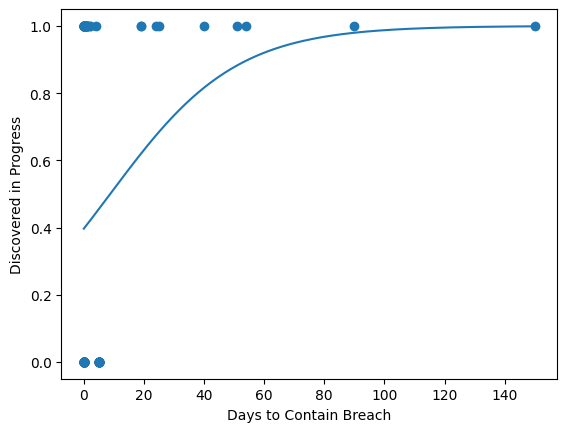

In [79]:
X = sample_df[["DaysToContainBreach"]].values.reshape(-1,1)
y = sample_df[["DiscoveredInProgress"]].values.reshape(-1,1).astype(int)
sample_df.loc[sample_df['DiscoveredInProgress'] == "False", "DiscoveredInProgress"] = 0
sample_df.loc[sample_df['DiscoveredInProgress'] == "True", "DiscoveredInProgress"] = 1
logisticModel = LogisticRegression()
logisticModel.fit(X, np.ravel(y.astype(int)))
plt.scatter(X, y)
xDelta = np.linspace(X.min(), X.max(), len(sample_df[['DaysToContainBreach']]))
yPred = logisticModel.predict(X).reshape(-1,1).astype(int)
yDeltaProb = logisticModel.predict_proba(xDelta.reshape(-1,1))[:,1]
plt.plot(xDelta, yDeltaProb)
plt.xlabel('Days to Contain Breach')
plt.ylabel('Discovered in Progress')

In [80]:
phat = logisticModel.predict_proba(X)
print("log loss = ", metrics.log_loss(y, phat))
absolute_loss = (np.sum(np.abs(yPred - phat)))/len(sample_df[['DaysToContainBreach']])
print("absolute log loss = ", absolute_loss, end='\n\n')

log loss =  0.6599448832080541
absolute log loss =  1.0



a large breach is usually seen right away but those seem to be harder to solve

There was a mismatch on the size of the X array, causing the absolute log loss to generate a large integer, so the numpy linspace was changed to the size of the data column. The absolute log loss is equal to one since the model is so one sided

# Train Test Split for Logistic

it isnt surprising the confusion matrix varies between values in the logistic plot, there is a jump from one side to the other

In [81]:
print(len(sample_df[['DaysToContainBreach']]))
print(len(sample_df[['DiscoveredInProgress']]))

143
143


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


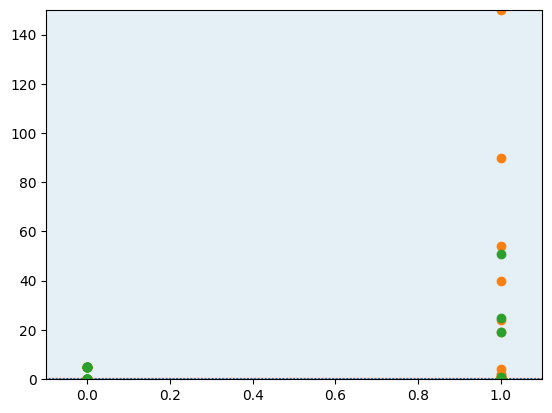

In [82]:
sample_df['DiscoveredInProgress'] = sample_df['DiscoveredInProgress'].astype(int)
sample_df.loc[sample_df['DiscoveredInProgress'] == "False", "DiscoveredInProgress"] = 0
sample_df.loc[sample_df['DiscoveredInProgress'] == "True", "DiscoveredInProgress"] = 1
sample_df[['opposite']] = 1 - sample_df[['DiscoveredInProgress']]
X = sample_df[['DaysToContainBreach','DiscoveredInProgress']]
y = sample_df[['opposite']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
model = LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
x_min, x_max = X['DiscoveredInProgress'].min() - 0.1, X['DiscoveredInProgress'].max() + 0.1
y_min, y_max = X['DaysToContainBreach'].min() - 0.1, X['DaysToContainBreach'].max() + 0.1
X1, X2 = np.meshgrid(np.linspace(x_min, x_max, 141), np.linspace(y_min, y_max, 141))
Z = model.predict(np.c_[X1.ravel(), X2.ravel()])
Z = Z.reshape(X1.shape)
plt.contourf(X1, X2, Z, alpha=0.3, cmap=plt.cm.Paired)
plt.scatter(X1, X2, Z)
plt.scatter(X_train['DiscoveredInProgress'], X_train['DaysToContainBreach'])
plt.scatter(X_test['DiscoveredInProgress'], X_test['DaysToContainBreach'])
plt.show()

this tecnique might be overdone, putting in a predicted plot was not working

# Cross Validation for Logistic

In [83]:
#"DaysToContainBreach" "DiscoveredInProgress"
sample_df['DiscoveredInProgress'] = sample_df['DiscoveredInProgress'].astype(int)
sample_df.loc[sample_df['DiscoveredInProgress'] == "False", "DiscoveredInProgress"] = 0
sample_df.loc[sample_df['DiscoveredInProgress'] == "True", "DiscoveredInProgress"] = 1
sample_df[['opposite']] = 1 - sample_df[['DiscoveredInProgress']]
print(sample_df[['opposite']])
print(sample_df[['DiscoveredInProgress']])

      opposite
1122         1
1000         1
555          1
693          0
945          0
...        ...
530          1
1044         1
280          0
938          0
915          1

[143 rows x 1 columns]
      DiscoveredInProgress
1122                     0
1000                     0
555                      0
693                      1
945                      1
...                    ...
530                      0
1044                     0
280                      1
938                      1
915                      0

[143 rows x 1 columns]


If there was a logistic plot done, then LOOCV values would meet it halfway, which is farther than the ten fold values for the mean squared error

In [84]:
X = sample_df[['DaysToContainBreach', 'DiscoveredInProgress']].values.reshape(-1,2)
y = sample_df[['opposite']].values.reshape(-1,1)
model = LogisticRegression()
scores = cross_val_score(model,X,y,cv=5,scoring='accuracy')
print('accuracy scores = ', scores)
print('mean accuracy = ', np.mean(scores), end='\n\n')

accuracy scores =  [1. 1. 1. 1. 1.]
mean accuracy =  1.0



/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

the logistic plot is very one sided so this seems reasonable

the cross validation shows similar results

# Bootstrap Method for Logistic

Looking back at the logistic model, the function is split at 0.5 starting at 0, and places value towards the case of the Discoverd in Progress being true for all values of the Days to contain the breach

In [85]:
#"DaysToIdentifyBreach" "DaysOfExposure"
copy = sample_df.copy()
bootstrapErrors = []
for i in range(0,40):
  boot = resample(copy, replace=True,n_samples=28)
  oob = copy[~copy.index.isin(boot.index)]

  XBoot = boot[['DaysToIdentifyBreach']].values.reshape(-1,1)
  yBoot = boot[['DaysOfExposure']].values.reshape(-1,1)
  linModel = LinearRegression()
  linModel.fit(XBoot, yBoot)
  XOob = oob[['DaysToIdentifyBreach']].values.reshape(-1,1)
  YOob = oob[['DaysOfExposure']].values.reshape(-1,1)
  YOobPredicted = linModel.predict(XOob)
  bootError = mean_squared_error(YOob, YOobPredicted)
  bootstrapErrors.append(bootError)
print("mean = ", np.mean(bootstrapErrors))
print("std dev = ", np.std(bootstrapErrors))
print("r squared = ", r2_score(YOob, YOobPredicted))

mean =  2051.311607684803
std dev =  542.1079230581441
r squared =  0.7101044162109251


this appears to give another similar mean squared error like the population

# Conclusion

From different samples and methods for the same data in the linear regression and the multiple regression, the mean squared errors are anywhere between 1500 to 2500 indicating they are related. For the logistic regression methods, there are similar values for log loss, and then the mean squared error. The r-squared values for most sets are around 0.76, showing there are trends. The different tecniques support each other and expected values.  